# Plotting ABF sampling data for alanine dipeptide
Here we plot the FES obtained via adaptive biasing force (ABF) for alanine dipeptide in TIP3P water.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
%matplotlib inline

Define 2D integrator (taken from SSAGES code, https://github.com/MICCoM/SSAGES-public)

In [2]:
def intgrad2(fx,fy,nx,ny,dx,dy,intconst,per1,per2):
    
    rhs = np.ravel((fy,fx))
    Af=np.zeros((4*nx*ny,3))
    
    n=0
    #Equations in x
    for i in range(0,nx):
        #Leading edge
        Af[2*ny*i][0] = 2*ny*i/2
        if(per2):
            Af[2*ny*i][1] = ny*i+(ny-1)
        else:
            Af[2*ny*i][1] = ny*i
        Af[2*ny*i][2] = -0.5/dx
    
        Af[2*ny*i+1][0] = 2*ny*i/2
        Af[2*ny*i+1][1] = ny*i+1
        Af[2*ny*i+1][2] = 0.5/dx

        #Loop over inner space
        for j in range(1,ny-1):
            Af[2*ny*i+2*j][0] = int((2*ny*i+2*j)/2)
            Af[2*ny*i+2*j][1] = ny*i+j
            Af[2*ny*i+2*j][2] = -1/dx
    
            Af[2*ny*i+2*j+1][0] = int((2*ny*i+2*j)/2)
            Af[2*ny*i+2*j+1][1] = ny*i+j+1
            Af[2*ny*i+2*j+1][2] = 1/dx

        #Trailing edge
        Af[2*ny*(i+1)-2][0] = int((2*ny*(i+1)-2)/2)
        Af[2*ny*(i+1)-2][1] = ny*i+(ny-2)
        Af[2*ny*(i+1)-2][2] = -0.5/dx
    
        Af[2*ny*(i+1)-1][0] = int((2*ny*(i+1)-2)/2)
        if(per2):
            Af[2*ny*(i+1)-1][1] = ny*i
        else:
            Af[2*ny*(i+1)-1][1] = ny*i+(ny-1)
        Af[2*ny*(i+1)-1][2] = 0.5/dx
    
    
    n=2*nx*ny
    #Equations in y
    #Leading edge
    for j in range(0,ny):

        Af[2*j+n][0] = 2*j/2 + n/2
        
        if(per1):
            Af[2*j+n][1] = (nx-1)*ny+j
        else:
            Af[2*j+n][1] = j
        Af[2*j+n][2] = -0.5/dy
    
        Af[2*j+n+1][0] = 2*j/2 + n/2
        Af[2*j+n+1][1] = j+ny
        Af[2*j+n+1][2] = 0.5/dy
    
    #Loop over inner space
    for i in range(1,nx-1):
        for j in range(0,ny):
            
            Af[2*ny*i+2*j+n][0] = int((2*ny*i+2*j+n)/2)
            Af[2*ny*i+2*j+n][1] = j+(i)*ny
            Af[2*ny*i+2*j+n][2] = -1/dy
    
            Af[2*ny*i+2*j+n+1][0] = int((2*ny*i+2*j+n)/2)
            Af[2*ny*i+2*j+n+1][1] = j+(i+1)*ny
            Af[2*ny*i+2*j+n+1][2] = 1/dy
            a=2*ny*i+2*j+n+1
    n=n+2*(nx-1)*ny
    
    #Trailing edge
    for j in range(0,ny):
        Af[2*j+n][0] = int((2*j+n)/2)
        Af[2*j+n][1] = (nx-2)*ny+j
        Af[2*j+n][2] = -0.5/dy
    
        Af[2*j+n+1][0] = int((2*j+n)/2)
        if(per1):
            Af[2*j+n+1][1] = j
        else:
            Af[2*j+n+1][1] = (nx-1)*ny+j
        Af[2*j+n+1][2] = 0.5/dy


    #Boundary conditions
    Af[0][2]=1
    Af[1][:]=0
    rhs[0] = intconst

    #Solve
    A=sps.csc_matrix((Af[:,2],(Af[:,0],Af[:,1])),shape=(2*nx*ny,nx*ny))
    fhat=spsl.lsmr(A,rhs)
    fhat=fhat[0]
    
    return fhat

Loop through data, and generate contour plots at different time intervals

In [3]:
dt = 0.002 # Timestep in fs. 
times = np.array([100, 500, 1000, 2500, 5000, 10000, 20000, 40000]) # Times at which to plot FES (ps).

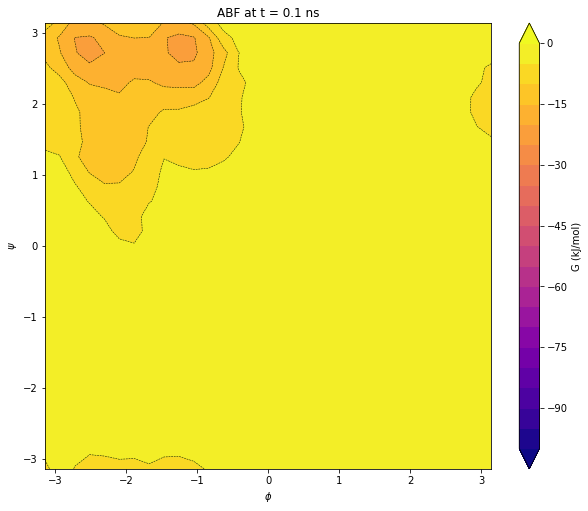

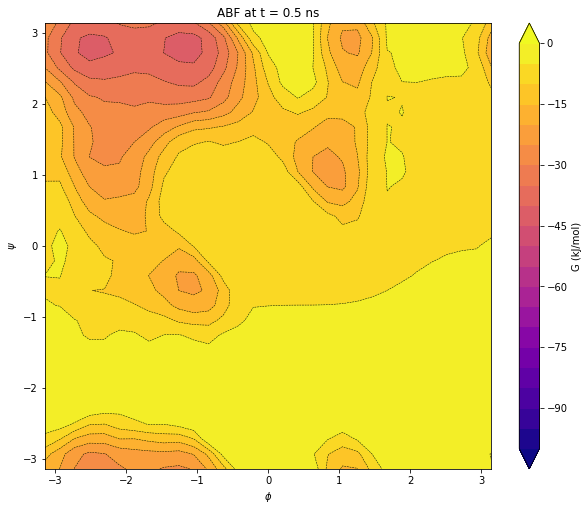

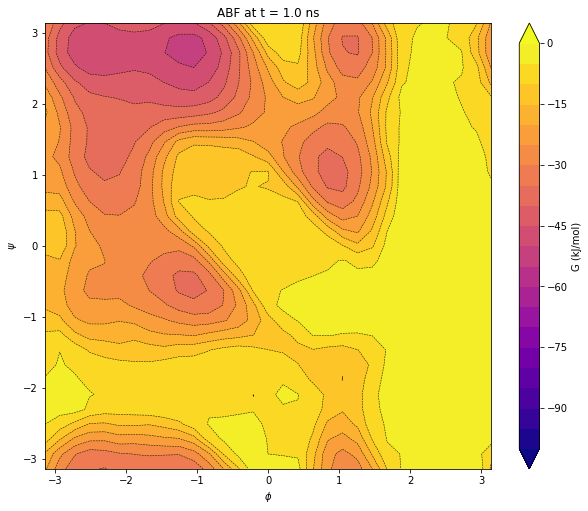

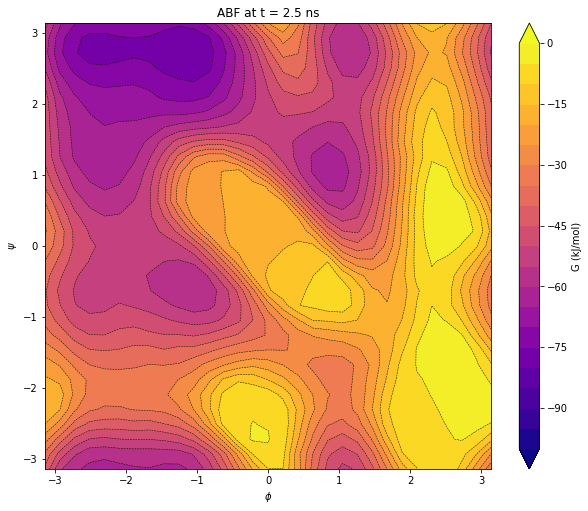

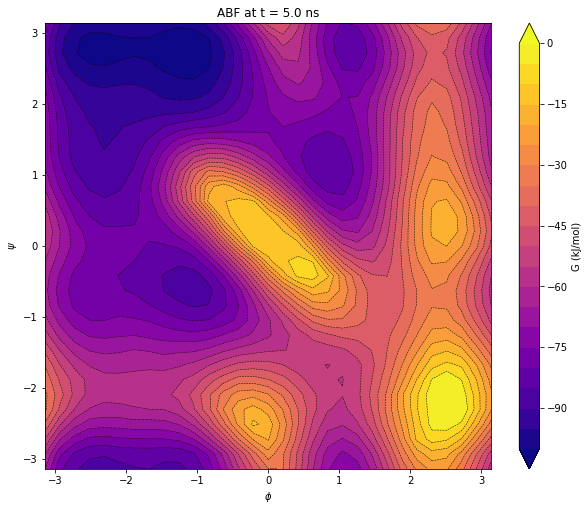

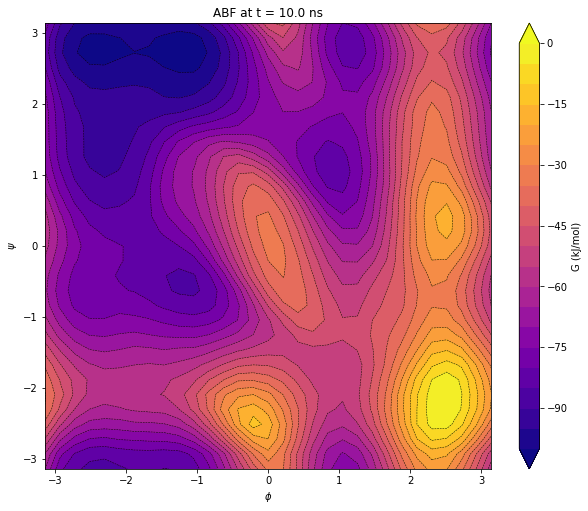

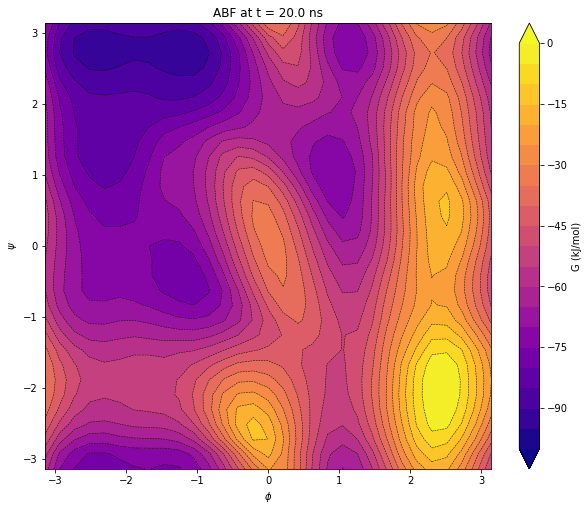

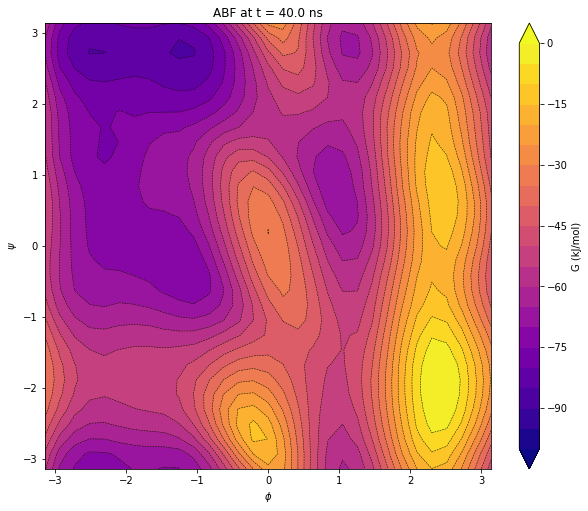

In [5]:
v = np.arange(-100, 5, 5) # Contours to plot.
for t in times:
    fig = plt.figure(figsize=(10, 8.2))
    frame = int(t/dt)
    X = np.loadtxt("data/F_out{0:d}".format(frame), skiprows=6)

    # Reshape, prep and call integrator.
    xg = X[:,0].reshape((31, 31))
    yg = X[:,1].reshape((31, 31))
    fy = X[:,2]
    fx = X[:,3]
    dx = (X[-1,0] - X[0,0])/31
    dy = (X[-1,1] - X[0,1])/31
    zg = -intgrad2(fx, fy, 31, 31, dx, dy, 1, True, True).reshape((31, 31))
    zg = zg - np.max(zg)
    
    # Plot data.
    plt.title("ABF at t = {} ns".format(t/1000.))
    plt.contour(xg, yg, zg, v, linewidths=0.5, colors="k")
    plt.contourf(xg, yg, zg, v, cmap=plt.cm.plasma, extend="both")
    cb = plt.colorbar()
    cb.set_label("G (kJ/mol)")
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.xlim((-np.pi, np.pi))
    plt.ylim((-np.pi, np.pi))
    plt.axis("equal")
    
    plt.savefig("abf_{:.1f}ns.png".format(t/1000.))